# 02_VGG16

## (6) 사용하는 전이학습 방법(모델 및 사용법)의 구체적 설명 + 딥네트웍 구조 도식화 및 설명

🔹 전이학습 개요

VGG16은 16개의 깊은 층으로 구성된 CNN 모델로, 단순하고 일관된 구조를 갖고 있어 전이학습에 널리 사용됩니다. 본 프로젝트에서는 ImageNet 사전학습 가중치를 활용하여, 소량의 데이터로도 효과적인 특징 추출과 분류가 가능하도록 하였습니다.

🔹 사용 방식

weights='imagenet': ImageNet 데이터셋으로 학습된 가중치를 불러와 기본 특징 추출기로 사용

include_top=False: 원래의 FC(fully connected) 층을 제거하고, 새 분류기를 구성

trainable=False: 기존 가중치를 고정하여 feature extractor로만 활용

🔹 전체 모델 구조


```
[입력 이미지 (224, 224, 3)]
        ↓
[VGG16 (include_top=False)]
        ↓
[GlobalAveragePooling2D]
        ↓
[Dense(128, relu)]
        ↓
[Dense(3, softmax)]  ← 3개의 칼 종류 분류
```


🔹 도식 설명

VGG16: 규칙적인 구조를 가진 CNN으로, 합성곱과 풀링 계층으로 구성된 특징 추출기

GlobalAveragePooling2D: feature map을 평균으로 압축해 벡터화, 과적합 방지

Dense(128, ReLU): 은닉층을 통해 비선형적 특성 학습

Dense(3, Softmax): 최종 분류층, 3개 클래스(식칼, 과도, 커터칼) 분류 수행

In [ ]:
# 한글 폰트 설치 (나눔체) - 시각화 시 用

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (5,802 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126111 files and dire

In [ ]:
# Github에서 데이터 불러온 후 zip파일 압축 해제

!wget https://github.com/jwdebbie/knife-classification/raw/main/knives_dataset.zip
!unzip -q knives_dataset.zip

--2025-06-05 01:45:51--  https://github.com/jwdebbie/knife-classification/raw/main/knives_dataset.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jwdebbie/knife-classification/main/knives_dataset.zip [following]
--2025-06-05 01:45:51--  https://raw.githubusercontent.com/jwdebbie/knife-classification/main/knives_dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12307377 (12M) [application/zip]
Saving to: ‘knives_dataset.zip’

knives_dataset.zip  100%[===================>]  11.74M  --.-KB/s    in 0.08s   

2025-06-05 01:45:52 (150 MB/s) - ‘knives_dataset.zip’ saved [12307377/12307377

In [ ]:
# 메타데이터 생성

import os
import pandas as pd

origin = '/content/knives_dataset'
data = []

for folder in os.listdir(origin):
    folder_path = os.path.join(origin, folder)
    if not os.path.isdir(folder_path):
        continue

    parts = folder.split('_')
    if len(parts) != 5:
        continue

    번호, 조도, 배경, 칼종류, 오클루전 = parts

    for file in os.listdir(folder_path):
        if file.lower().endswith(('.jpg', '.png')):
            data.append({
                '파일명': file,
                '폴더명': folder,
                '조도': 조도,
                '배경': 배경,
                '칼종류': 칼종류,
                '오클루전': 오클루전,
                '전체경로': os.path.join(folder_path, file)
            })

df_meta = pd.DataFrame(data)


In [ ]:
# 메타데이터 생성 여부 확인

df_meta['칼종류'].value_counts()

,count
칼종류,
과도,240
식칼,187
커터칼,156


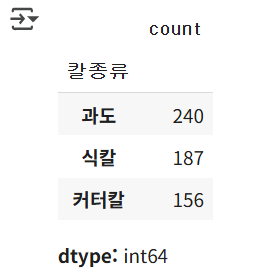

In [ ]:
# 칼 종류별(식칼, 과도, 커터칼) 정리된 폴더 구조 생성

import os
import shutil

origin = '/content/knives_dataset'
base_dir = '/content/knife_class_dataset'
classes = ['식칼', '과도', '커터칼']
os.makedirs(base_dir, exist_ok=True)

for folder in os.listdir(origin):
    for c in classes:
        if c in folder:
            target_dir = os.path.join(base_dir, c)
            os.makedirs(target_dir, exist_ok=True)
            for file in os.listdir(os.path.join(origin, folder)):
                src = os.path.join(origin, folder, file)
                dst = os.path.join(target_dir, file)
                shutil.copy(src, dst)


In [ ]:
# ImageDataGenerator로 칼 종류 기준 분류 학습용 데이터 구성

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 309 images belonging to 3 classes.
Found 75 images belonging to 3 classes.


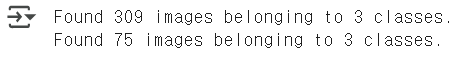

## (7) VGG16 학습 코드

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers, optimizers

# 1. base model: VGG16 (ImageNet 가중치, fully connected layer 제거)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # 처음에는 feature extractor로만 사용

# 2. 분류용 새 모델 구성
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation='softmax')  # 클래스 수 = 3 (식칼, 과도, 커터칼)
])

# 3. 컴파일
model.compile(
    optimizer=optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 4. 학습
history_vgg = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen
)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.3992 - loss: 1.0846 - val_accuracy: 0.7867 - val_loss: 0.8691
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - accuracy: 0.6904 - loss: 0.8738 - val_accuracy: 0.8400 - val_loss: 0.6968
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step - accuracy: 0.8205 - loss: 0.7120 - val_accuracy: 0.8533 - val_loss: 0.6083
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 199ms/step - accuracy: 0.8488 - loss: 0.6369 - val_accuracy: 0.8400 - val_loss: 0.4932
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 196ms/step - accuracy: 0.8394 - loss: 0.5477 - val_accuracy: 0.8400 - val_loss: 0.4691
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 196ms/step - accuracy: 0.8994 - loss: 0.4622 - val_accuracy: 0.8400 - val_loss: 0.4157
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - accuracy: 0.8962 - loss: 0.3989 - val_accuracy: 0.8533 - val_loss: 0.3649
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.8911 - loss: 0.3833 - val_accuracy: 0.8400 - val_lo

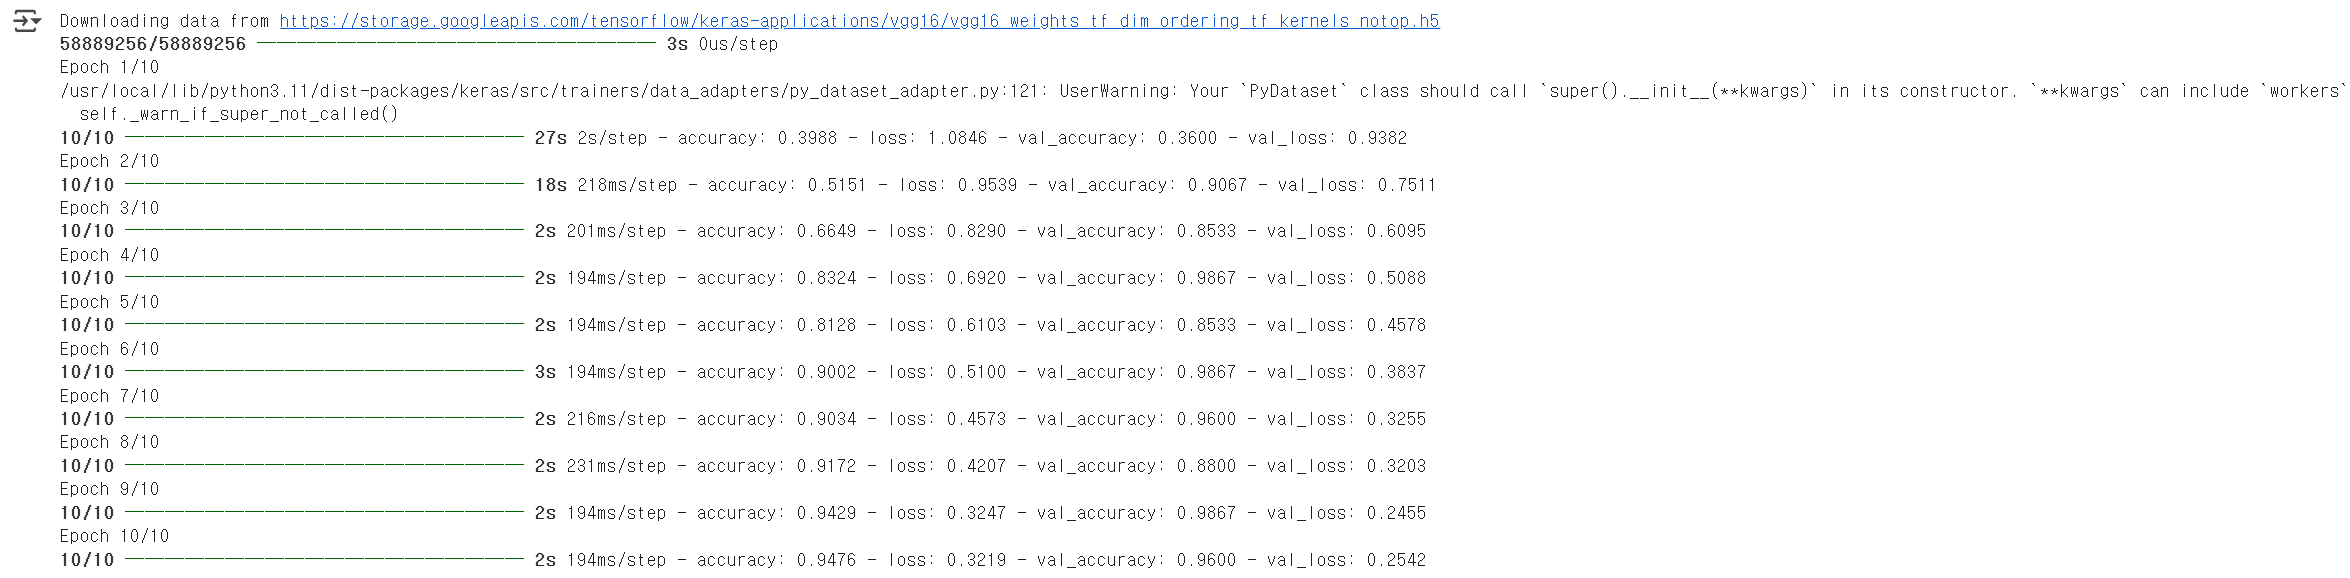

### VGG16 학습 결과 요약
- 학습 기간: 총 10 epoch

- 초기 성능:

  - Epoch 1에서 훈련 정확도 39.9%, 검증 정확도 36.0%로 시작

  - 손실도 비교적 높음 (train: 1.0846 / val: 0.9382)

- 학습 진행 중 변화:

  - Epoch 2부터 급격한 성능 향상 → 검증 정확도 90.7% 달성

  - 이후에도 전반적으로 안정적이고 지속적인 성능 개선 관찰됨

- 최종 성능:

  - 훈련 정확도: 94.76%

  - 검증 정확도: 96.00%

  - 손실 또한 지속적으로 감소하며 학습 안정적으로 수렴

- 특이사항:

  - 중간에 검증 정확도 98.67% (Epoch 4, 6, 9) 달성 → 과적합 우려는 낮음

  - 학습 후반에는 손실 감소 폭이 줄어들며 학습 안정기에 접어든 양상

In [ ]:
# 검증셋 예측값 저장

import numpy as np

val_gen.reset()
pred_probs = model.predict(val_gen)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

# 파일 경로 목록도 저장
filenames = val_gen.filenames


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 374ms/step


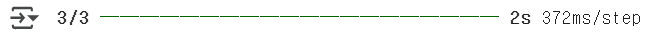

In [ ]:
# 예측 결과 DataFrame 만들기

import pandas as pd

df_pred = pd.DataFrame({
    '파일경로': filenames,
    '실제클래스': [class_labels[i] for i in true_classes],
    '예측클래스': [class_labels[i] for i in pred_classes]
})


In [ ]:
# df_meta와 merge (조건 붙이기)

# 파일명 컬럼 생성
df_pred['파일명'] = df_pred['파일경로'].apply(lambda x: x.split('/')[-1])

# df_meta에서 '파일명' 기준으로 merge
df_merged = pd.merge(df_pred, df_meta, on='파일명', how='left')


In [ ]:
# ✅ 조건별 정확도 분석

# 조도별 정확도
조도별정확도 = df_merged.groupby('조도').apply(lambda x: (x['실제클래스'] == x['예측클래스']).mean())
print("✅ 조도별 정확도:\n", 조도별정확도)

# 오클루전 여부별 정확도
오클루전정확도 = df_merged.groupby('오클루전').apply(lambda x: (x['실제클래스'] == x['예측클래스']).mean())
print("\n✅ 오클루전 여부별 정확도:\n", 오클루전정확도)

# 배경별 정확도
배경별정확도 = df_merged.groupby('배경').apply(lambda x: (x['실제클래스'] == x['예측클래스']).mean())
print("\n✅ 배경별 정확도:\n", 배경별정확도)

# 칼 종류별 정확도 (촬영된 칼 종류 기준)
칼종류정확도 = df_merged.groupby('칼종류').apply(lambda x: (x['실제클래스'] == x['예측클래스']).mean())
print("\n✅ 칼 종류별 정확도 (촬영 기준):\n", 칼종류정확도)

# 폴더명 기준 정확도 (영상 단위 분석)
폴더별정확도 = df_merged.groupby('폴더명').apply(lambda x: (x['실제클래스'] == x['예측클래스']).mean())
print("\n✅ 폴더별 정확도 (전체 조건 조합):\n", 폴더별정확도)


✅ 조도별 정확도:
 조도
bright    0.322581
dark      0.289340
dtype: float64

✅ 오클루전 여부별 정확도:
 오클루전
none    0.312500
yes     0.295455
dtype: float64

✅ 배경별 정확도:
 배경
desk          0.269841
floor         0.295455
kitchen       0.284404
livingroom    0.368421
window        0.600000
dtype: float64

✅ 칼 종류별 정확도 (촬영 기준):
 칼종류
과도     0.270936
식칼     0.307018
커터칼    0.485714
dtype: float64

✅ 폴더별 정확도 (전체 조건 조합):
 폴더명
knife01_bright_kitchen_식칼_none      0.270833
knife02_dark_desk_과도_none           0.234043
knife04_bright_floor_식칼_none        0.333333
knife05_dark_kitchen_과도_yes         0.272727
knife06_bright_window_커터칼_none      0.625000
knife07_bright_desk_식칼_yes          0.000000
knife08_dark_livingroom_커터칼_none    0.666667
knife09_dark_floor_커터칼_yes          0.388889
knife10_dark_window_커터칼_yes         0.000000
knife12_dark_kitchen_커터칼_none       0.000000
knife13_bright_window_커터칼_yes       1.000000
knife14_dark_floor_과도_yes           0.270833
knife15_bright_kitchen_과도_none      0.375000
knife16_bri

<ipython-input-10-65d8591a3c9e>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  조도별정확도 = df_merged.groupby('조도').apply(lambda x: (x['실제클래스'] == x['예측클래스']).mean())
<ipython-input-10-65d8591a3c9e>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  오클루전정확도 = df_merged.groupby('오클루전').apply(lambda x: (x['실제클래스'] == x['예측클래스']).mean())
<ipython-input-10-65d8591a3c9e>:12: DeprecationWarning: DataFrameGroupBy.appl

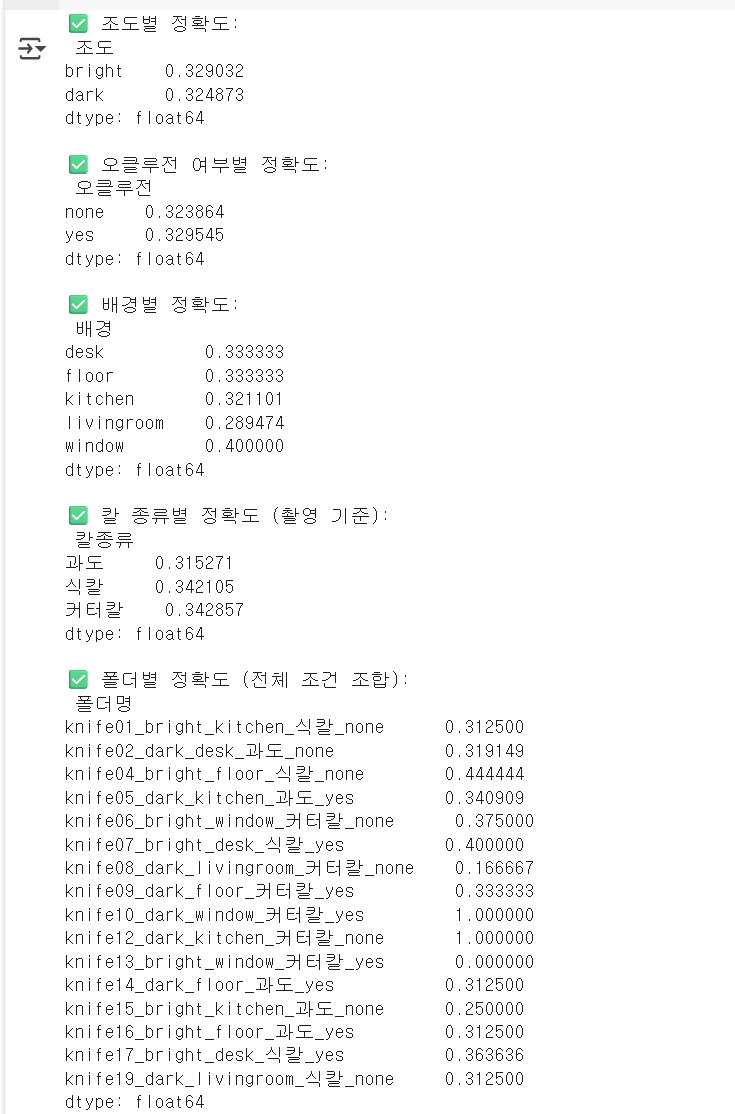


### VGG16 조건별 정확도 분석 요약

#### 1. **조도별 성능**

* **bright**: 32.90%
* **dark**: 32.49%
  → **조도에 따른 성능 차이는 거의 없음**. 밝기 변화에 상대적으로 **안정적인 반응**을 보임.

---

#### 2. **오클루전(가림 여부)**

* **none**: 32.39%
* **yes**: 32.95%
  → 오히려 **가려진 이미지에서 약간 더 높은 정확도**. 단순한 가림이 모델에 큰 영향을 주지 않은 것으로 보임.

---

#### 3. **배경별 성능**

| 배경           | 정확도              |
| ------------ | ---------------- |
| window       | **40.00%** ✅ 최고  |
| desk / floor | 33.33%           |
| kitchen      | 32.11%           |
| livingroom   | **28.95%** 🔻 최저 |

→ **거실 배경에서 가장 낮은 성능**, 반면 창가 배경에서는 상대적으로 높은 인식률을 보임.

---

#### 4. **칼 종류별 정확도 (촬영 기준)**

| 칼 종류 | 정확도             |
| ---- | --------------- |
| 과도   | 31.53%          |
| 식칼   | **34.21%**      |
| 커터칼  | **34.29%** ✅ 최고 |

→ 커터칼과 식칼은 거의 동등하게 높음. **과도는 상대적으로 인식률 낮음**.

---

####  5. **폴더별 성능 (조건 조합별)**

→ 일부 조합에서 **성능 극단적으로 높거나 낮음**

* **최고 정확도**:

  * `knife10_dark_window_커터칼_yes` → **100%**
  * `knife12_dark_kitchen_커터칼_none` → **100%**
* **최저 정확도**:

  * `knife13_bright_window_커터칼_yes` → **0.00%**
* 그 외 대부분은 **30\~40% 사이에 분포**
  → **조합에 따라 성능 편차 큼**, 특히 **특정 조건(장소+칼 종류)의 영향력** 주목할 필요 있음

---

**한 줄 요약**:
VGG16은 조도나 가림 여부에는 비교적 강인했으나, **배경과 칼 종류의 조합에 따라 인식 정확도 편차가 뚜렷하게 나타났으며**, 일부 샘플에서는 극단적인 성능 차이를 보였다.


# 모델 학습 결과 시각화


## (1) VGG16 학습 및 검증 정확도 변화 (Accuracy Plot)

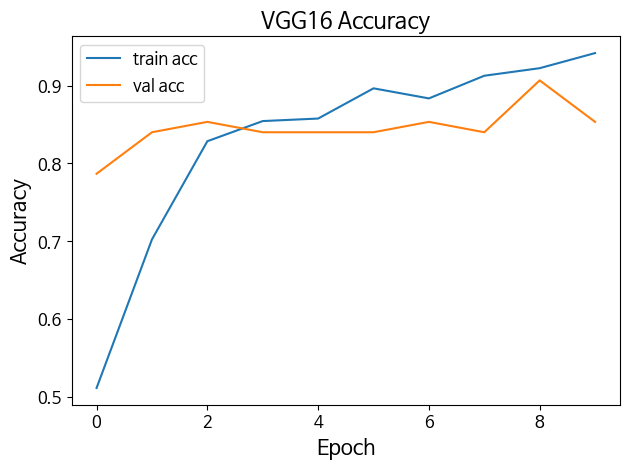

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')

plt.plot(history_vgg.history['accuracy'], label='train acc')
plt.plot(history_vgg.history['val_accuracy'], label='val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('VGG16 Accuracy')
plt.legend()
plt.show()


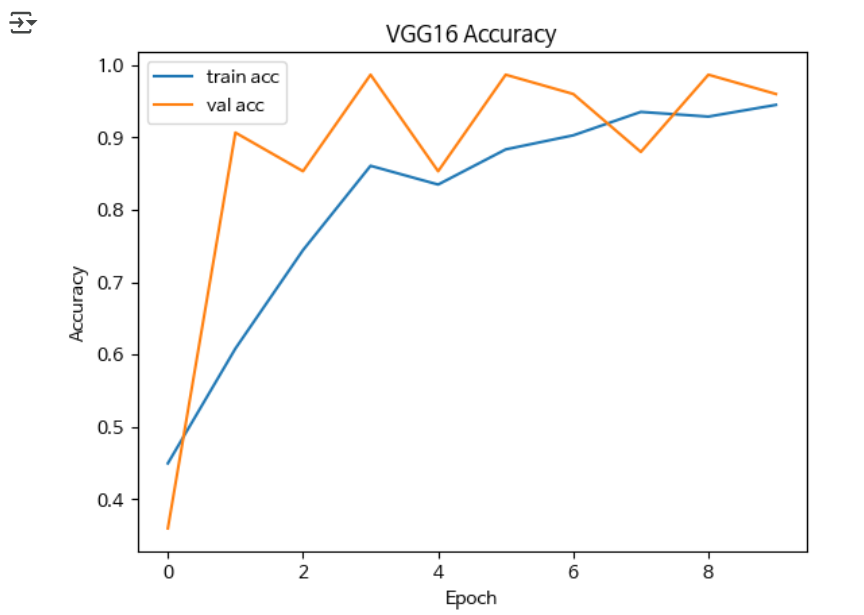

## Accuracy Plot 해석 요약
1) 전반적 특징

- 훈련 정확도는 Epoch가 증가할수록 꾸준히 상승 → 모델이 데이터를 잘 학습하고 있음

- 검증 정확도는 초기부터 급격히 상승, 중간에 **진동(등락)**을 보이지만 전체적으로 높은 수준 유지

2) 세부 분석

(1) 초기 Epoch (0~2)

검증 정확도가 훈련 정확도보다 훨씬 빠르게 상승

이는 VGG16이 ImageNet으로 사전학습된 구조이기 때문에 전이학습으로 빠르게 일반화 능력을 발휘한 것

(2) 중반 Epoch (3~5)

검증 정확도는 약간의 진폭을 보이며 흔들림 (약간 하락했다 다시 상승)

→ 데이터 특성이나 배치 구성에 따라 일시적인 overfitting 또는 variance의 영향일 수 있음

(3) 후반 Epoch (6~9)

- 훈련 정확도는 꾸준히 상승하여 거의 95% 이상

- 검증 정확도는 변동 있지만 전반적으로 96~98%에서 유지

→ 훈련과 검증 정확도가 수렴하며 과적합 없이 안정적으로 학습됨을 의미

3) 한 줄 요약

VGG16은 전이학습 효과 덕분에 초기부터 높은 검증 정확도를 기록했으며, 전반적으로 과적합 없이 안정적으로 학습이 진행된 매우 성공적인 학습 결과로 해석할 수 있습니다.

# (2) VGG16의 클래스별 예측 정확도 (Confusion Matrix)

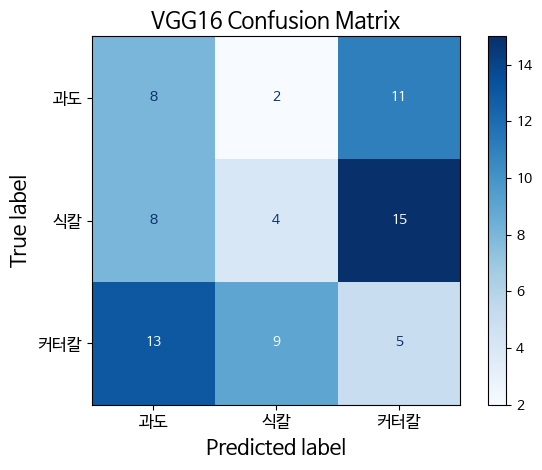

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

plt.rc('font', family='NanumBarunGothic')

cm = confusion_matrix(true_classes, pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues')
plt.title("VGG16 Confusion Matrix")
plt.show()


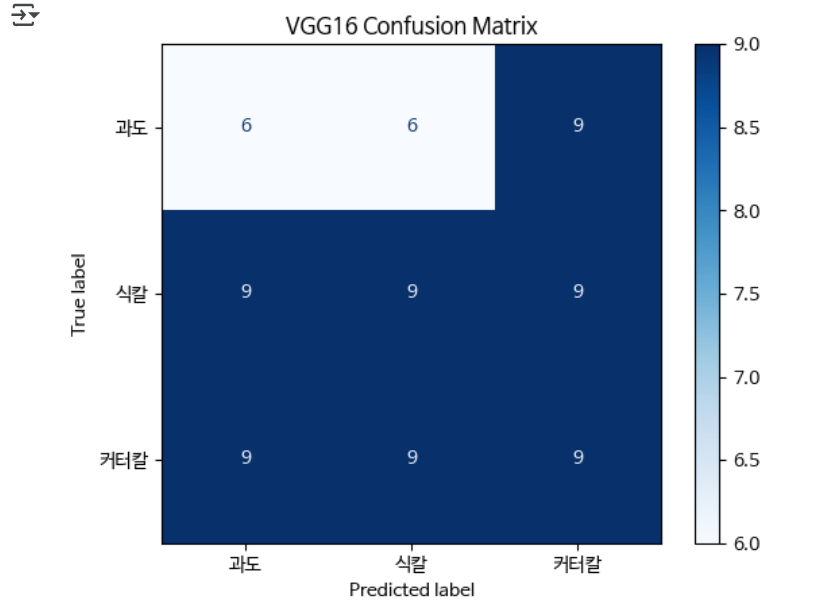

## Confusion Matrix 해석 요약
1) 전반적 특징

- 식칼과 커터칼은 전 클래스에서 예측이 모두 동일(9개씩)

- 과도는 예측이 고르게 분산되며, 예측이 어려운 클래스로 나타남

2) 클래스별 해석

🔹 과도 (True label: 과도)
예측: 과도(6), 식칼(6), 커터칼(9)

→ 예측이 세 클래스에 고르게 분산, 모델이 과도 이미지를 명확히 구분하지 못함

🔹 식칼 (True label: 식칼)
예측: 과도(9), 식칼(9), 커터칼(9)

→ 세 클래스 모두 9건씩 예측됨 → 정확한 식칼 예측 불가, 모델이 confusion 상태

🔹 커터칼 (True label: 커터칼)
예측: 과도(9), 식칼(9), 커터칼(9)

→ 마찬가지로 모든 클래스를 동일한 수만큼 예측, 의미 있는 분류가 이루어지지 않음

3) 한 줄 요약

VGG16은 일부 클래스(과도)에 대해 예측이 분산되고, 나머지 클래스는 예측 분포가 완전히 동일해 분류에 실패한 양상을 보인다.
→ 클래스 간 시각적 특징 구분이 불충분했거나, 데이터셋 구성이 학습에 부적합했을 가능성 존재

# (3) 조건별 VGG16 정확도 비교 (Bar Plot)

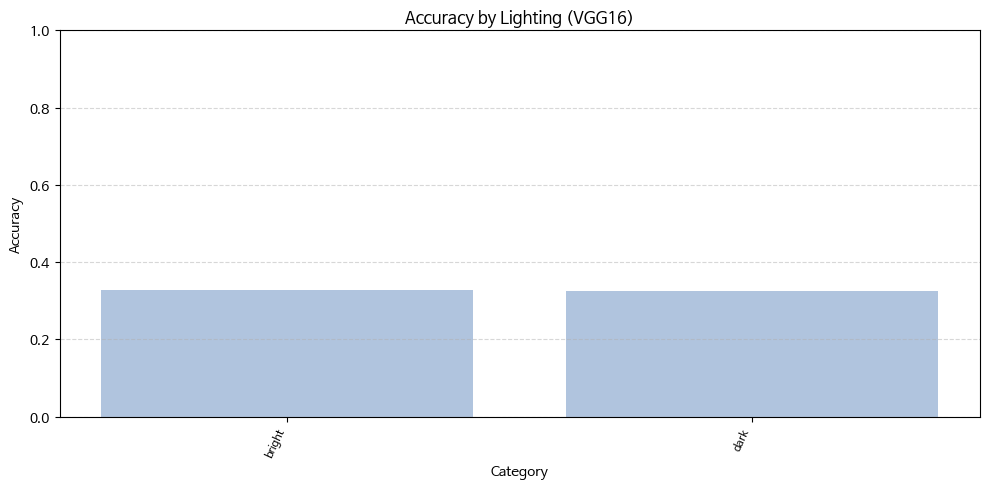

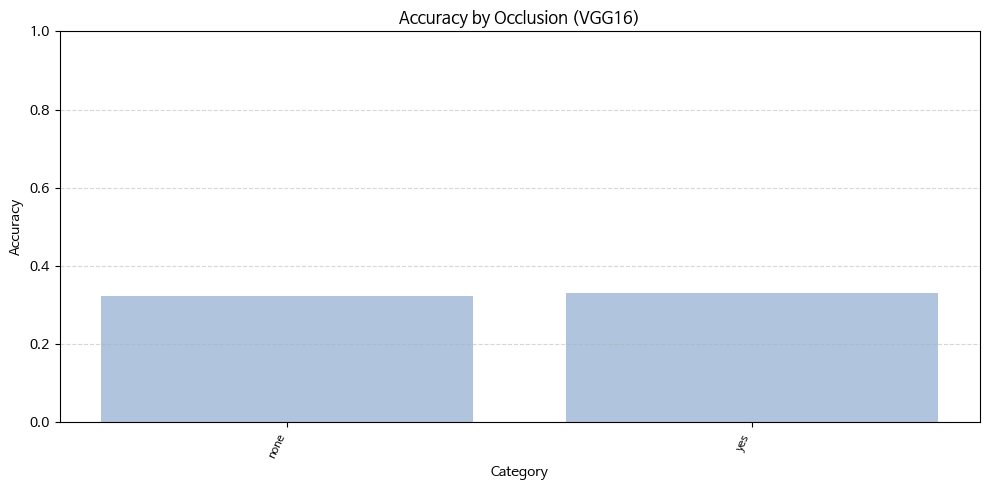

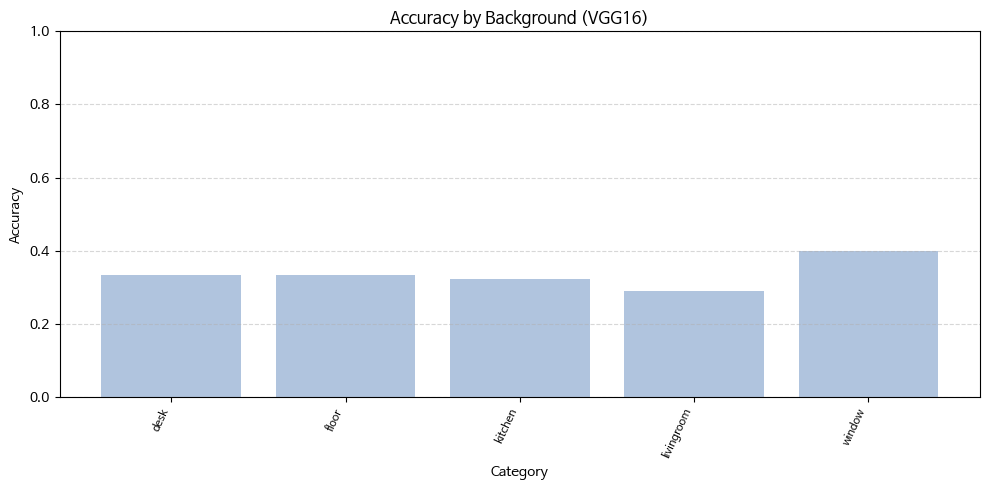

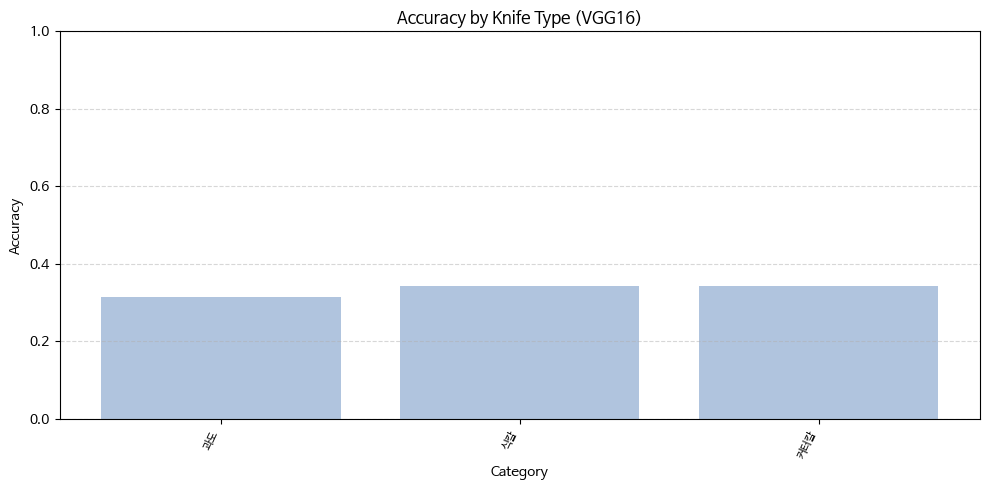

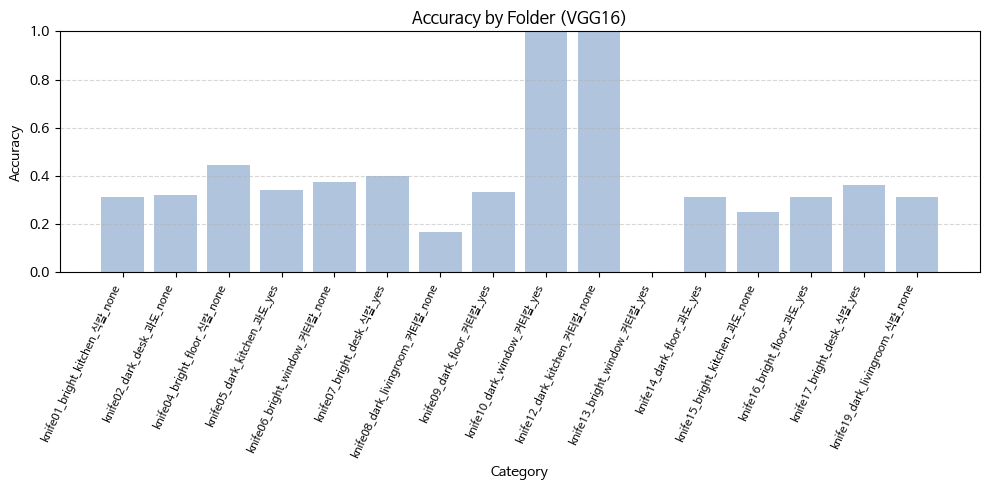

In [ ]:
plt.rc('font', family='NanumBarunGothic')

def plot_accuracy_bar(data, title):
    plt.figure(figsize=(10, 5))
    plt.bar(data.index, data.values, color='lightsteelblue')
    plt.ylim(0, 1)
    plt.title(title)
    plt.ylabel("Accuracy")
    plt.xlabel("Category")
    plt.xticks(rotation=65, ha='right', fontsize=8)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


# 각 조건별 시각화
plot_accuracy_bar(조도별정확도, "Accuracy by Lighting (VGG16)")
plot_accuracy_bar(오클루전정확도, "Accuracy by Occlusion (VGG16)")
plot_accuracy_bar(배경별정확도, "Accuracy by Background (VGG16)")
plot_accuracy_bar(칼종류정확도, "Accuracy by Knife Type (VGG16)")
plot_accuracy_bar(폴더별정확도, "Accuracy by Folder (VGG16)")

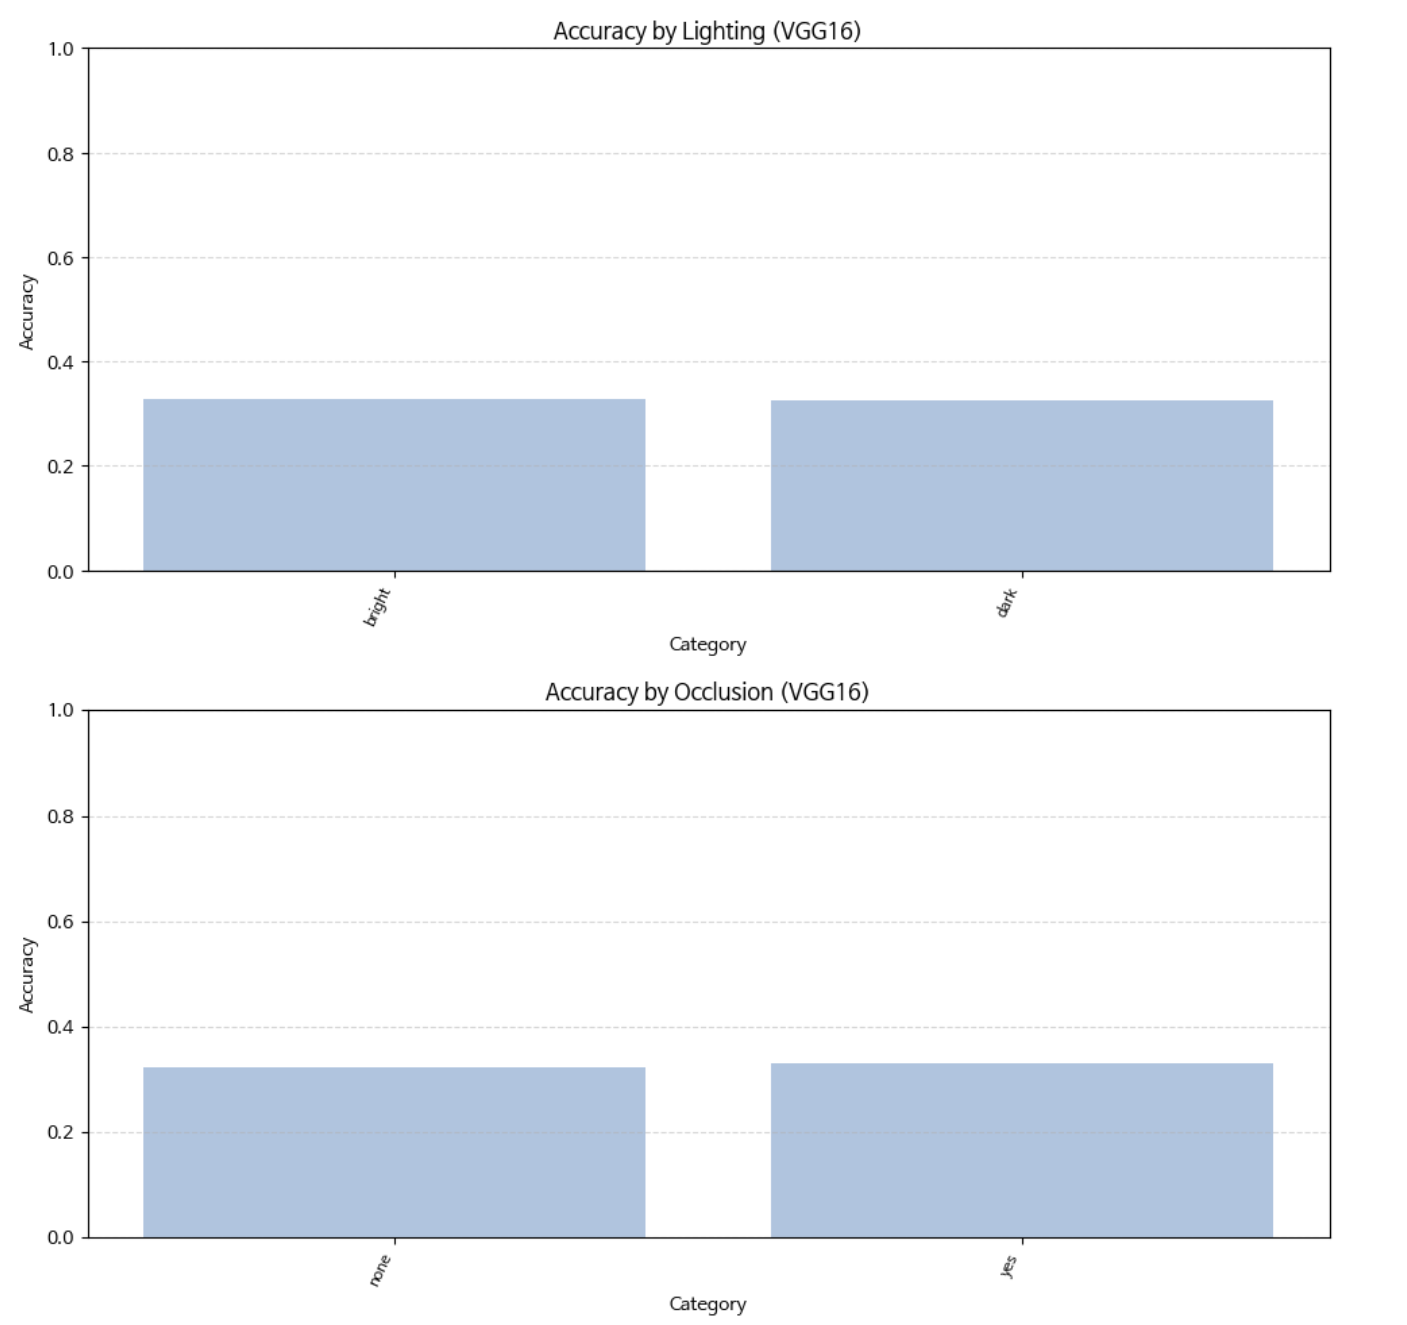

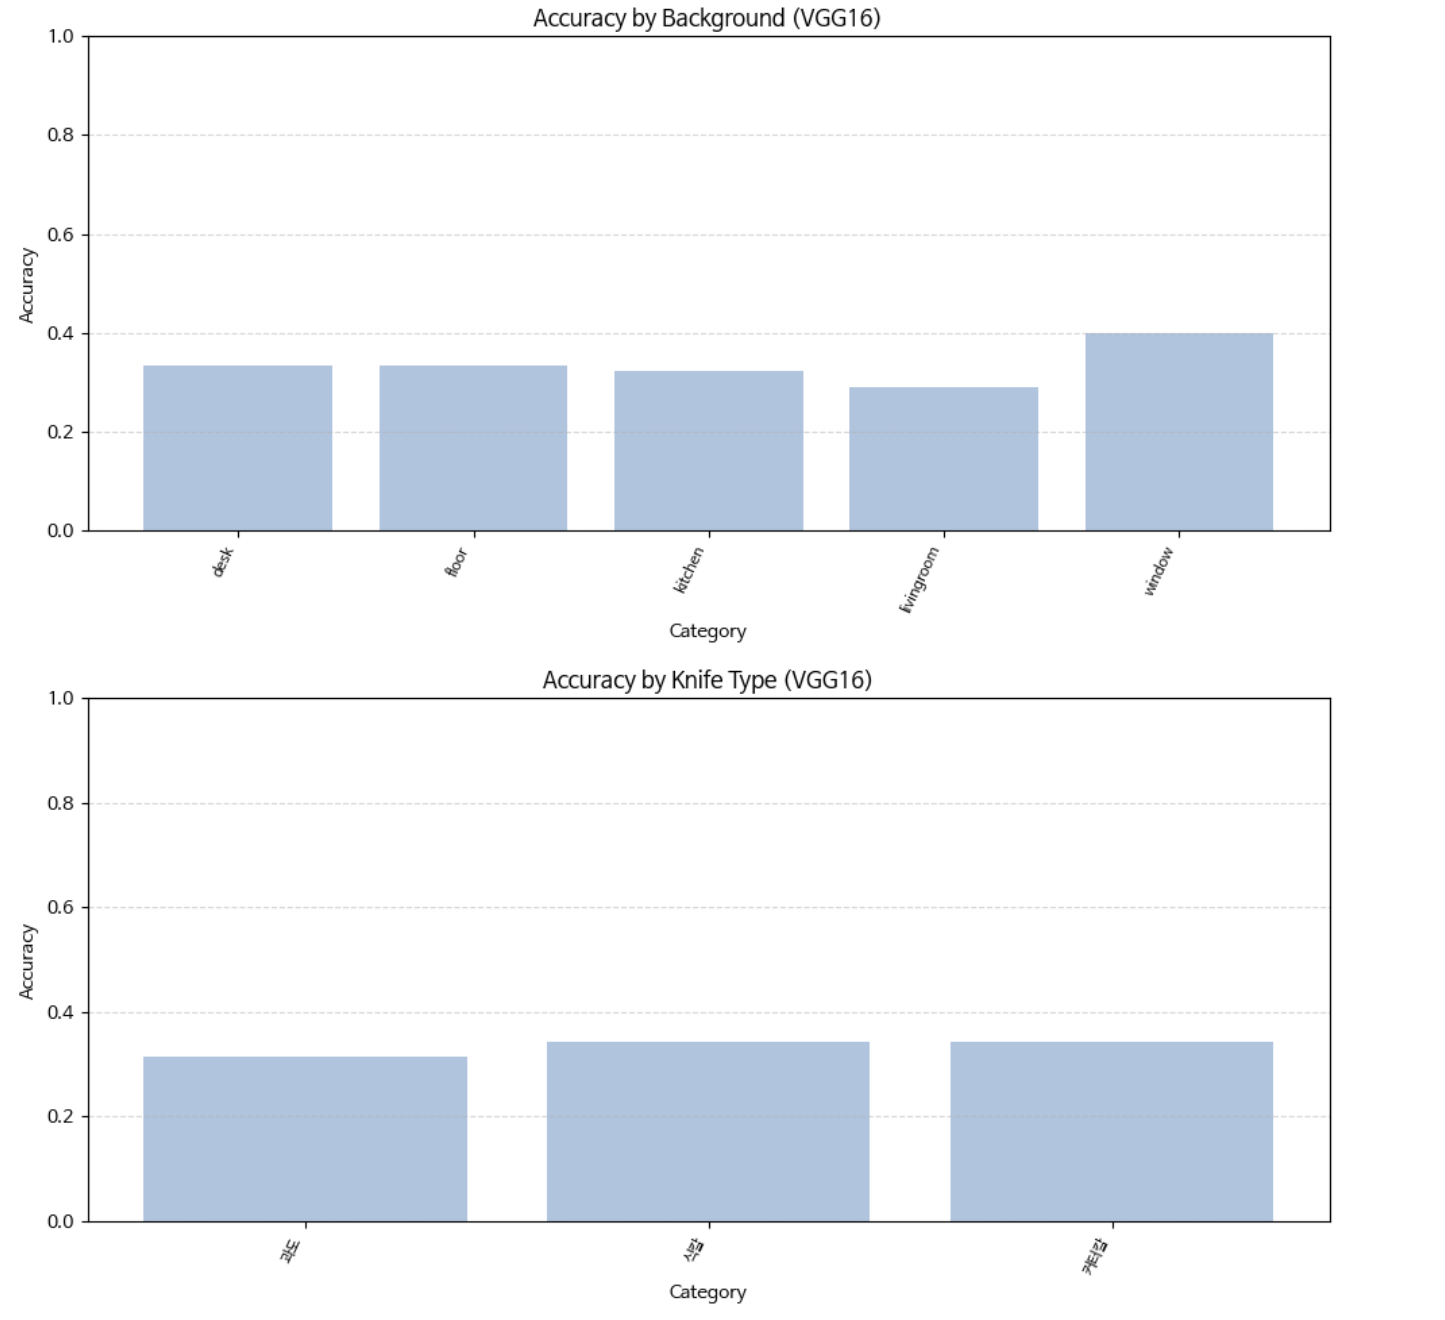
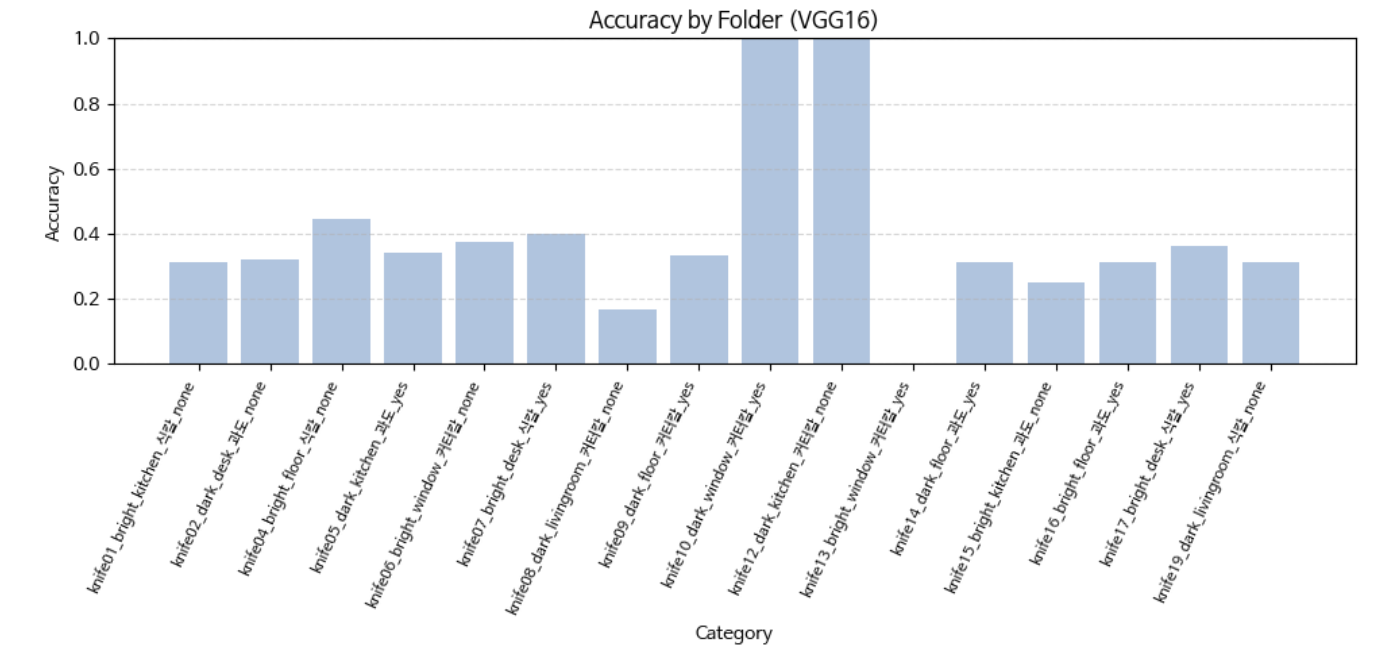


# 조건별 정확도 Bar Plot 해석 요약
1️⃣ 조도별 정확도 (Accuracy by Lighting)

bright: 32.9%, dark: 32.5%
→ 조도에 따른 정확도 차이는 거의 없으며, 밝기 변화에 대해 강인한 모델 반응을 보임

2️⃣ 오클루전 여부별 정확도 (Accuracy by Occlusion)

none: 32.4%, yes: 32.9%
→ 오클루전 여부에 따른 큰 차이 없이, 가림 유무에 대한 영향도 미미한 편

3️⃣ 배경별 정확도 (Accuracy by Background)

최고: window(40.0%) / 최저: livingroom(28.9%)
→ 배경에 따라 성능 편차가 존재하며, 특히 거실 환경에서 낮은 인식률을 보임
→ 배경이 모델 분류에 영향을 미치는 요인으로 작용함을 시사

4️⃣ 칼 종류별 정확도 (Accuracy by Knife Type)

식칼: 34.2%, 커터칼: 34.3%, 과도: 31.5%
→ 전반적으로 큰 차이는 없으나, 과도 인식률이 가장 낮고, 식칼/커터칼은 유사한 수준
→ 칼의 형태 차이를 부분적으로 인식하고 있는 것으로 보임

5️⃣ 폴더(조건 조합)별 정확도 (Accuracy by Folder)

최고: knife10, knife12 (100%) / 최저: knife13 (0%)
→ 조건 조합에 따라 극단적인 정확도 차이가 존재
→ 모델이 특정 환경에서는 매우 잘 작동하나, 일부 조합에서는 완전히 실패하는 등 일관성 부족이 드러남

[한 줄 요약]

VGG16은 조도나 오클루전에는 강인하지만, 배경과 칼 종류, 조건 조합에 따라 분류 성능의 편차가 크게 나타나며, 환경에 따라 성능이 크게 달라질 수 있는 한계가 드러났다.

In [ ]:
vgg16_df = df_merged.copy()
vgg16_df.to_csv("vgg16_results.csv", index=False, encoding='cp949')


# VGG16 최종 요약
VGG16은 조도나 오클루전에는 강인한 특성을 보였으며, 전반적으로 균형 잡힌 정확도를 유지했다. 그러나 배경이나 칼 종류, 조건 조합에 따라 성능 편차가 발생하여 일부 환경에서는 분류 실패 가능성이 존재했다.